In [1]:
import pandas as pd
import re
import string
import numpy as np

from src.nnmf_pipeline import NNMFPipelineEnglish
from src.lsa_pipeline import LSAPipelineEnglish
#change dataset path
df = pd.read_csv('data/processed/en_tweets_processed.csv')
df = df[df.language == 'en']
df = df[~df['text'].isna()]
preprocessed_documents = df['text'].tolist()


/tmp/ipykernel_295780/1233439838.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Selection of N_topics

In [2]:
n_components_range = [5,10,15,20,25,30,35,40,45,50,70,100]
scores = []
for n in n_components_range:
    NNMFPipeline =  LSAPipelineEnglish(preprocessed_documents,ngram_range=(1,2),lsa_components=n,svd_n_iter=1000,tf_idf_max_df=0.9,tf_idf_min_df=4,random_state=0)
    topics1 = NNMFPipeline.run_topics_detection()
    current_score = NNMFPipeline.calculate_coherence_score()
    print(f'Current score {current_score}, n_components = {n}')
    scores.append(current_score)

Current score 0.7562434732130454, n_components = 5
Current score 0.6040203682794274, n_components = 10
Current score 0.5942475893910515, n_components = 15
Current score 0.5395704325417294, n_components = 20
Current score 0.5103243164135471, n_components = 25
Current score 0.488714455367448, n_components = 30
Current score 0.46693683599442914, n_components = 35
Current score 0.4489662322714024, n_components = 40
Current score 0.4338518258798709, n_components = 45
Current score 0.42292028988471325, n_components = 50
Current score 0.3859773788160002, n_components = 70
Current score 0.3565811495546549, n_components = 100


In [3]:
import json

res = json.dumps(dict(zip(n_components_range,scores)))
res
with open('./metrics/LSA_custom_number_of_topics.json','w') as f:
    f.write(res)


In [4]:
current_score

0.3565811495546549

In [2]:
import json

with open('./metrics/NMF_sklearn_number_of_topics.json','r') as sklearn_metrics_file:
    sklearn_metrics = json.load(sklearn_metrics_file)
    
with open('./metrics/NMF_custom_number_of_topics.json','r') as sklearn_metrics_file:
    custom_NMF_metrics = json.load(sklearn_metrics_file)
    
with open('./metrics/LSA_custom_number_of_topics.json','r') as sklearn_metrics_file:
    custom_LSA_metrics = json.load(sklearn_metrics_file)

/tmp/ipykernel_342146/2591901246.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


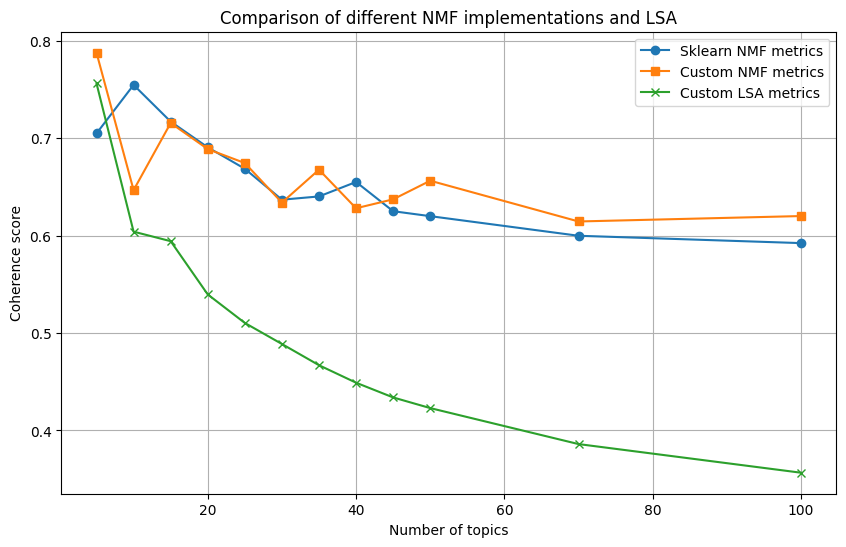

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
df1 = pd.DataFrame(list(sklearn_metrics.items()), columns=['X', 'Y'])
df2 = pd.DataFrame(list(custom_NMF_metrics.items()), columns=['X', 'Y'])
df3 = pd.DataFrame(list(custom_LSA_metrics.items()), columns=['X', 'Y'])
# Convert the 'X' column to numeric values for proper plotting
df1['X'] = pd.to_numeric(df1['X'])
df2['X'] = pd.to_numeric(df2['X'])
df3['X'] = pd.to_numeric(df3['X'])

plt.figure(figsize=(10, 6))

plt.plot(df1['X'], df1['Y'], label='Sklearn NMF metrics', marker='o')
plt.plot(df2['X'], df2['Y'], label='Custom NMF metrics', marker='s')
plt.plot(df3['X'], df3['Y'], label='Custom LSA metrics', marker='x')

plt.title('Comparison of different NMF implementations and LSA')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


TypeError: unhashable type: 'dict'

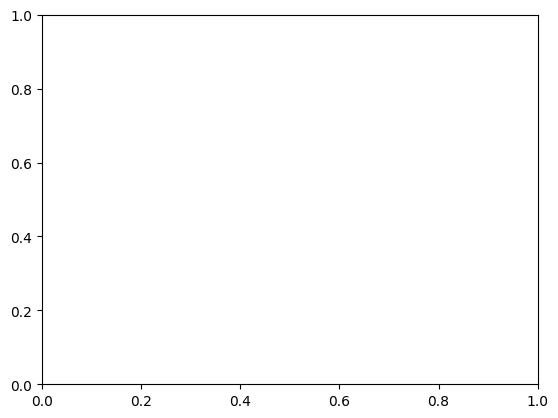

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sklearn_metrics)

6 30 no numba - 40

In [ ]:
best_n_components = n_components_range[np.argmax(scores)]

In [ ]:
NNMFPipeline =  NNMFPipelineEnglish(preprocessed_documents,ngram_range=(1,2),n_components=5,max_iter=1000,tf_idf_max_df=0.9,tf_idf_min_df=4,random_state=0)
topics1 = NNMFPipeline.run_topics_detection()
NNMFPipeline.calculate_coherence_score()

In [ ]:
lsa_pipeline = LSAPipelineEnglish(preprocessed_documents,ngram_range=(1,2),lsa_components=5,svd_n_iter=200,tf_idf_max_df=0.9,tf_idf_min_df=4,random_state=0)
topics2 = lsa_pipeline.run_topics_detection()
lsa_pipeline.calculate_coherence_score()

## Topic Modeling per month (not all data used)

In [3]:
import os 
import pandas as pd
from src.nnmf_pipeline import NNMFPipelineEnglish
from src.lsa_pipeline import LSAPipelineEnglish

csv_files = [x for x in os.listdir('data/montly_data') if x.endswith('csv')]

In [5]:
import pandas as pd
import gc  # Garbage collection
from pathlib import Path

# Assuming `NNMFPipelineEnglish` is defined elsewhere and properly imported

def read_and_process_csv(file_path, usecols=['text'], subset='text'):
    """Read CSV file for specific columns, handle exceptions, and preprocess data."""
    try:
        df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)
    except pd.errors.ParserError:
        df = pd.read_csv(file_path, lineterminator='\n', usecols=usecols).drop_duplicates(subset=subset)
    df.dropna(subset=[subset], inplace=True)
    return df['text']

def extract_topics(documents):
    """Wrapper for NMF topic extraction and coherence score calculation."""
    pipeline = LSAPipelineEnglish(documents, ngram_range=(1, 2), lsa_components=10, svd_n_iter=200,
                                tf_idf_max_df=0.9, tf_idf_min_df=4, random_state=0)
    topics = pipeline.run_topics_detection()
    score = pipeline.calculate_coherence_score()
    return topics, score

# Main processing loop
topics_per_file = {}
data_path = Path('data/montly_data')

for csv_file in data_path.glob('*.csv'):
    documents = read_and_process_csv(csv_file)
    if not documents.empty:
        topics, score = extract_topics(documents)
        date = '_'.join(csv_file.stem.split('_')[:2])
        print(date, score)
        topics_per_file[date] = {'cv_score': score, 'topics': topics}
        
    del documents  # Explicitly delete the variable to free up memory
    gc.collect()  # Manually trigger garbage collection


/tmp/ipykernel_305427/1040954581.py:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)


2023_04 0.7303353880173566


/tmp/ipykernel_305427/1040954581.py:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)


2022_08 0.6729020110175763


/tmp/ipykernel_305427/1040954581.py:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)


2023_01 0.614480298269292


/tmp/ipykernel_305427/1040954581.py:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)


2023_02 0.6900796254977525
2022_12 0.7735829279839717
2022_11 0.8332661538352036
2022_09 0.6859715780786539


/tmp/ipykernel_305427/1040954581.py:10: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=usecols).drop_duplicates(subset=subset)


2023_03 0.7280571182868314
2023_05 0.705537990965623
2022_10 0.6238616106319237


In [6]:
import json
file_path = 'topics_per_file_custom_LSA.json'

with open(file_path, 'w') as json_file:
    json.dump(topics_per_file, json_file, indent=4)

In [4]:
import seaborn as sns

with open('metrics/topics_per_file.json','r') as sklearn_metrics_file:
    custom_NMF_metrics = json.load(sklearn_metrics_file)
    
with open('metrics/topics_per_file_custom.json','r') as sklearn_metrics_file:
     sklearn_metrics = json.load(sklearn_metrics_file)
    
with open('metrics/topics_per_file_custom_LSA.json','r') as sklearn_metrics_file:
    custom_LSA_metrics = json.load(sklearn_metrics_file)

In [5]:
custom_LSA_metrics

{'2023_04': {'cv_score': 0.7303353880173566,
  'topics': [['russian',
    'bakhmut',
    'footage',
    'ukrainian',
    'ukraine',
    'attack',
    'troop',
    'drone',
    'soldier',
    'horrible'],
   ['ukraine',
    'war',
    'ukraine war',
    'video',
    'russia',
    'war video',
    'video footage',
    'drone attack',
    'drone',
    'attack'],
   ['drone',
    'ukrainian drone',
    'drop',
    'drone drop',
    'soldier',
    'bomb',
    'russian soldier',
    'drop bomb',
    'ukrainian',
    'grenade'],
   ['footage',
    'war video',
    'video footage',
    'video',
    'attack russian',
    'russian soldier',
    'drone attack',
    'bakhmut',
    'gopro',
    'gopro footage'],
   ['soldier',
    'gopro',
    'gopro footage',
    'russian soldier',
    'ukrainian troop',
    'attack russian',
    'ukrainian',
    'troop',
    'russian',
    'brutally'],
   ['russia',
    'black sea',
    'black',
    'sea',
    'fleet',
    'sea fleet',
    'attack',
    'massive'

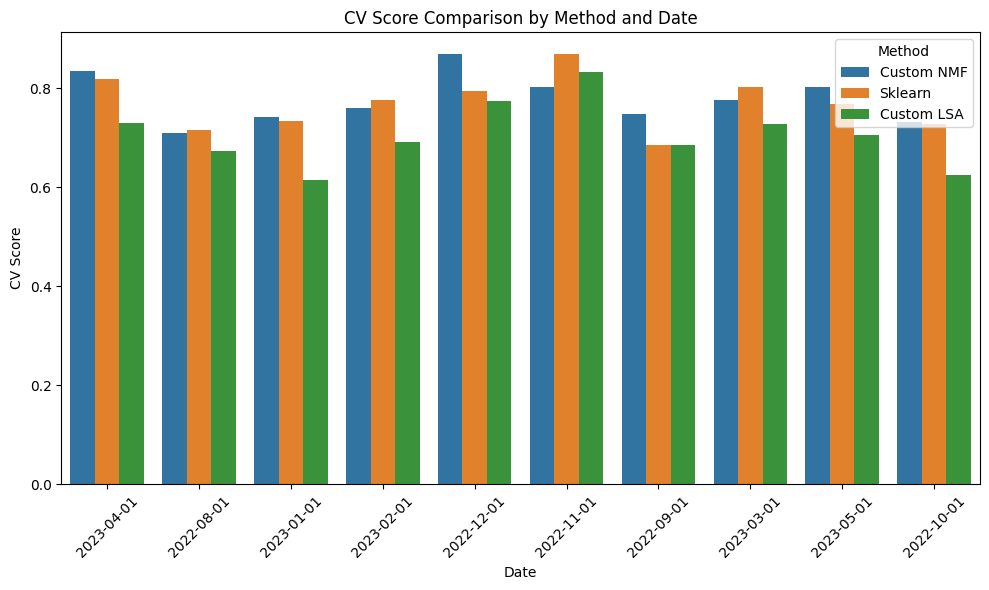

In [6]:
import matplotlib.pyplot as plt 

df_custom_NMF = pd.DataFrame([
    {"date": pd.to_datetime(date, format='%Y_%m'), "cv_score": values['cv_score'], "method": "Custom NMF"}
    for date, values in custom_NMF_metrics.items()
])

df_sklearn = pd.DataFrame([
    {"date": pd.to_datetime(date, format='%Y_%m'), "cv_score": values['cv_score'], "method": "Sklearn"}
    for date, values in sklearn_metrics.items()
])

df_LSA = pd.DataFrame([
    {"date": pd.to_datetime(date, format='%Y_%m'), "cv_score": values['cv_score'], "method": "Custom LSA"}
    for date, values in custom_LSA_metrics.items()
])
# Concatenating all DataFrames
df_all = pd.concat([df_custom_NMF, df_sklearn, df_LSA])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x="date", y="cv_score", hue="method", data=df_all)
plt.title('CV Score Comparison by Method and Date')
plt.xlabel('Date')
plt.ylabel('CV Score')
plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()
plt.show()


In [7]:
df_all.groupby('method')['cv_score'].mean()

method
Custom LSA    0.705807
Custom NMF    0.777352
Sklearn       0.768787
Name: cv_score, dtype: float64

In [10]:
df_custom_NMF

,date,cv_score
0,2023-04-01,0.834584
1,2022-08-01,0.709741
2,2023-01-01,0.742039
3,2023-02-01,0.759257
4,2022-12-01,0.868363
5,2022-11-01,0.802044
6,2022-09-01,0.747827
7,2023-03-01,0.776089
8,2023-05-01,0.801947
9,2022-10-01,0.731628


In [ ]:
pd.read_csv('data/processed/en_tweets_processed.csv')

In [ ]:
0.7048616049254076